# pyspectacle API Example

This notebook demonstrates how to use the pyspectacle parser API to analyze lunar spectra from the RELAB database.

In [2]:
# Setup
from pyspectacle import RelabParser
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Initialize parser
parser = RelabParser('/mnt/c/Users/cjtai/Downloads/RelabDatabase2024Dec31')

ModuleNotFoundError: No module named 'pyspectacle'

## 1. Explore the Database

In [ ]:
# How many samples and spectra?
print(f"Samples: {len(parser.sample_catalogue):,}")
print(f"Spectra: {len(parser.spectra_catalogue):,}")

# What sample sources are available?
print("\nSample sources:")
print(parser.sample_catalogue['Source'].value_counts().head(10))

Samples: 16,526
Spectra: 33,199

Sample sources:
Source
Earth        10765
Other-Met     2490
Synthetic     1956
Moon-Ret      1103
Mars-Met       107
Moon-Met        66
Other-Vet       16
Other-Ast       12
Other-Qet        4
Earth-Met        3
Name: count, dtype: int64


## 2. Find Lunar Basalt Samples

In [ ]:
# Query for lunar basalts
lunar_basalts = parser.list_spectra(Source='Moon-Ret', SubType='Basalt')
print(f"Found {len(lunar_basalts)} lunar basalt spectra")

# Display first few
lunar_basalts[['SpectrumID', 'SampleID', 'SampleName', 'Origin', 'Date']].head(10)

Found 47 lunar basalt spectra


,SpectrumID,SampleID,SampleName,Origin,Date
3090,BIR1DD035,DD-MDD-035,"12021,257 coarse particles ~100 um","Apollo 12 site, Moon",12-May-04
3091,BKR1DD035,DD-MDD-035,"12021,257 coarse particles ~100 um","Apollo 12 site, Moon",12-May-04
3092,C1DD35,DD-MDD-035,"12021,257 coarse particles ~100 um","Apollo 12 site, Moon",12-May-04
3093,BIR1DD036,DD-MDD-036,"12021,258 coarse particles ~50 um","Apollo 12 site, Moon",12-May-04
3094,BKR1DD036,DD-MDD-036,"12021,258 coarse particles ~50 um","Apollo 12 site, Moon",12-May-04
3095,C1DD36,DD-MDD-036,"12021,258 coarse particles ~50 um","Apollo 12 site, Moon",12-May-04
14314,C2LS01,LS-CMP-001,"15555,798",Apollo 15,5-Dec-85
14315,S2LS01,LS-CMP-001,"15555,798",Apollo 15,5-Dec-85
14316,C1LS01,LS-CMP-001,"15555,798",Apollo 15,6-Dec-85
14317,S1LS01,LS-CMP-001,"15555,798",Apollo 15,6-Dec-85


## 3. Load and Plot Multiple Spectra

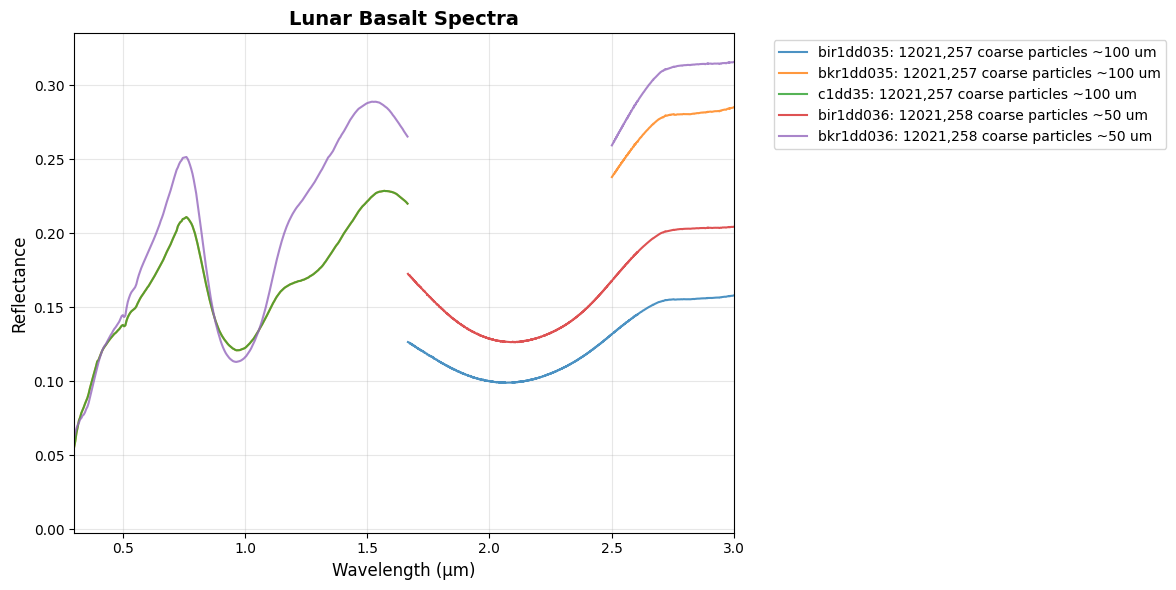

In [ ]:
# Select first 5 lunar basalt spectra
spectrum_ids = lunar_basalts['SpectrumID'].iloc[:5].tolist()

# Retrieve spectra
refl_df, std_df, meta_df = parser.get_spectra_batch(spectrum_ids)

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
for col in refl_df.columns:
    sample_name = meta_df.loc[col, 'SampleName']
    ax.plot(refl_df.index, refl_df[col], label=f"{col}: {sample_name}", alpha=0.8)

ax.set_xlabel('Wavelength (μm)', fontsize=12)
ax.set_ylabel('Reflectance', fontsize=12)
ax.set_title('Lunar Basalt Spectra', fontsize=14, fontweight='bold')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(alpha=0.3)
ax.set_xlim(0.3, 3)
plt.tight_layout()
plt.show()

## 4. Interpolate to Common Grid

Interpolated shape: (440, 5)
No missing data: False


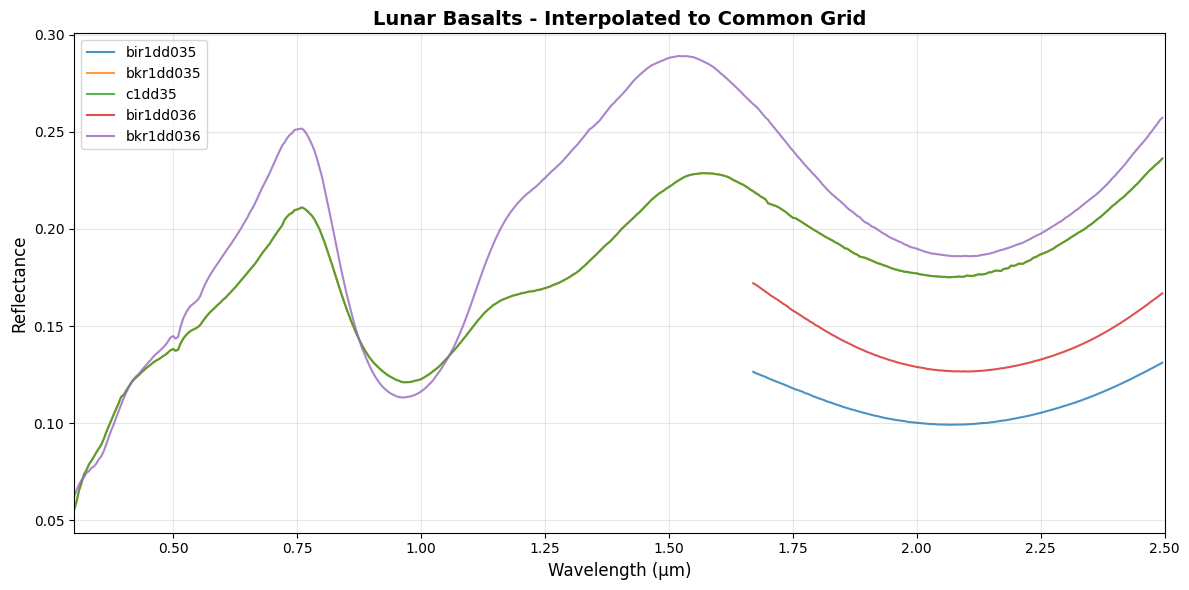

In [ ]:
# Create uniform wavelength grid: 300-2500 nm with 5 nm resolution
wl_grid = np.arange(0.3, 2.5, 0.005)

# Interpolate all spectra
refl_interp, std_interp, meta_interp = parser.get_spectra_batch(
    spectrum_ids,
    wavelength_grid=wl_grid,
    interpolation='cubic'
)

# Now all spectra have same wavelength points
print(f"Interpolated shape: {refl_interp.shape}")
print(f"No missing data: {refl_interp.isna().sum().sum() == 0}")

# Plot interpolated spectra
fig, ax = plt.subplots(figsize=(12, 6))
for col in refl_interp.columns:
    ax.plot(refl_interp.index, refl_interp[col], label=col, alpha=0.8)

ax.set_xlabel('Wavelength (μm)', fontsize=12)
ax.set_ylabel('Reflectance', fontsize=12)
ax.set_title('Lunar Basalts - Interpolated to Common Grid', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)
ax.set_xlim(0.3, 2.5)
plt.tight_layout()
plt.show()

## 5. Calculate Spectral Parameters

In [ ]:
# Calculate 1 μm absorption band depth for each spectrum
def band_depth_1um(wavelengths, reflectance):
    """Calculate 1 μm band depth."""
    # Find wavelengths around 1 μm band
    idx_750 = np.argmin(np.abs(wavelengths - 0.75))
    idx_1000 = np.argmin(np.abs(wavelengths - 1.0))
    idx_1250 = np.argmin(np.abs(wavelengths - 1.25))
    
    # Linear continuum
    continuum = np.interp(
        wavelengths[idx_1000],
        [wavelengths[idx_750], wavelengths[idx_1250]],
        [reflectance[idx_750], reflectance[idx_1250]]
    )
    
    # Band depth
    bd = 1 - (reflectance[idx_1000] / continuum)
    return bd

# Calculate for all spectra
band_depths = {}
for col in refl_interp.columns:
    bd = band_depth_1um(refl_interp.index.values, refl_interp[col].values)
    band_depths[col] = bd
    
# Display results
bd_df = pd.DataFrame.from_dict(band_depths, orient='index', columns=['Band Depth (1 μm)'])
bd_df['SampleName'] = [meta_interp.loc[idx, 'SampleName'] for idx in bd_df.index]
bd_df.sort_values('Band Depth (1 μm)', ascending=False)

,Band Depth (1 μm),SampleName
bkr1dd036,0.512694,"12021,258 coarse particles ~50 um"
bkr1dd035,0.353608,"12021,257 coarse particles ~100 um"
c1dd35,0.353608,"12021,257 coarse particles ~100 um"
bir1dd035,NaN,"12021,257 coarse particles ~100 um"
bir1dd036,NaN,"12021,258 coarse particles ~50 um"


## 6. Compare Spectra with Ratios

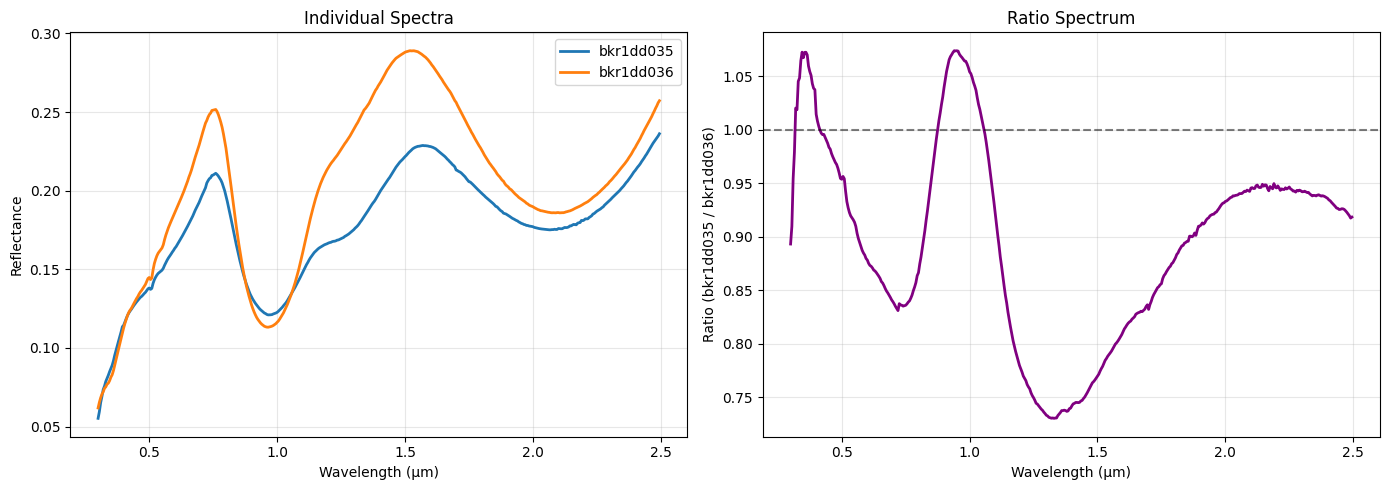

In [ ]:
# Compare two spectra
spectrum_1 = 'bkr1dd035'
spectrum_2 = 'bkr1dd036'

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Individual spectra
ax1.plot(refl_interp.index, refl_interp[spectrum_1], label=spectrum_1, linewidth=2)
ax1.plot(refl_interp.index, refl_interp[spectrum_2], label=spectrum_2, linewidth=2)
ax1.set_xlabel('Wavelength (μm)')
ax1.set_ylabel('Reflectance')
ax1.set_title('Individual Spectra')
ax1.legend()
ax1.grid(alpha=0.3)

# Ratio spectrum
ratio = refl_interp[spectrum_1] / refl_interp[spectrum_2]
ax2.plot(refl_interp.index, ratio, linewidth=2, color='purple')
ax2.axhline(y=1, color='k', linestyle='--', alpha=0.5)
ax2.set_xlabel('Wavelength (μm)')
ax2.set_ylabel(f'Ratio ({spectrum_1} / {spectrum_2})')
ax2.set_title('Ratio Spectrum')
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Plot Spectra with Error Bars

In this section, we will plot the reflectance spectra with standard deviations as error bars, if available.

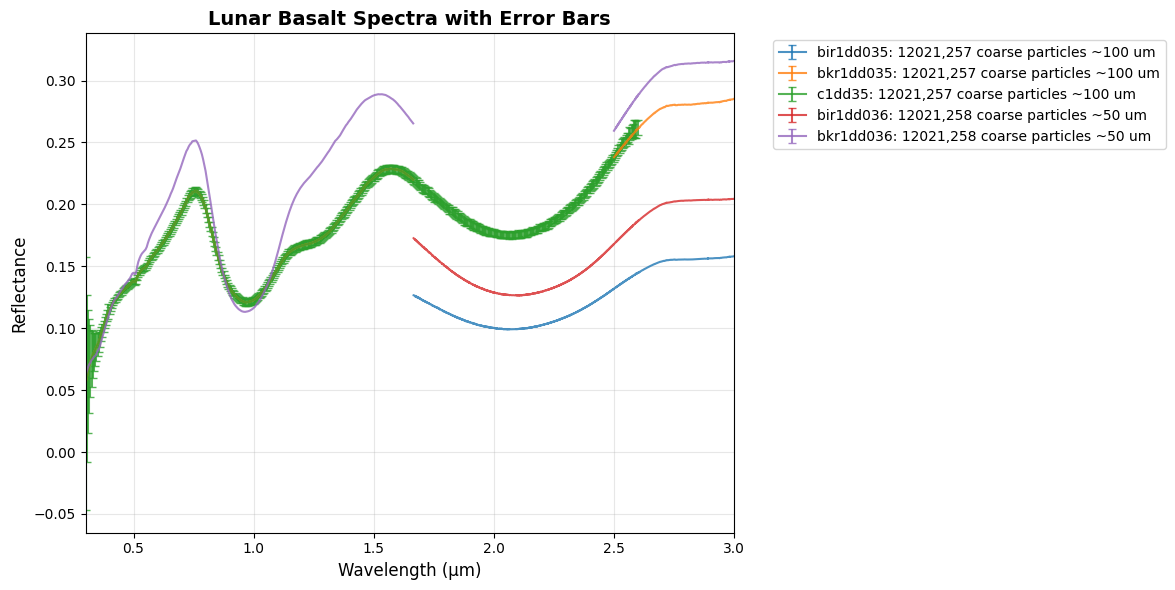

In [ ]:
# Plot spectra with error bars
fig, ax = plt.subplots(figsize=(12, 6))

# Iterate through the first few spectra
for col in refl_df.columns[:5]:
    sample_name = meta_df.loc[col, 'SampleName']
    reflectance = refl_df[col]
    std_dev = std_df[col] if col in std_df else None  # Check if std_dev is available

    # Plot with error bars if std_dev is available
    if std_dev is not None:
        ax.errorbar(
            refl_df.index, reflectance, yerr=std_dev, label=f"{col}: {sample_name}",
            fmt='-', capsize=3, alpha=0.8
        )
    else:
        ax.plot(refl_df.index, reflectance, label=f"{col}: {sample_name}", alpha=0.8)

ax.set_xlabel('Wavelength (μm)', fontsize=12)
ax.set_ylabel('Reflectance', fontsize=12)
ax.set_title('Lunar Basalt Spectra with Error Bars', fontsize=14, fontweight='bold')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(alpha=0.3)
ax.set_xlim(0.3, 3)
plt.tight_layout()
plt.show()

## Tips

- Use `list_spectra()` to explore available samples before loading data
- Interpolate to common grid when doing quantitative comparisons
- Check `meta_df` for measurement conditions (angles, date, instrument)
- Standard deviations (`std_df`) indicate measurement uncertainty
- NaN values indicate missing data or out-of-range wavelengths